In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import seaborn as sns
import random

# 讀取資料

In [2]:
df = pd.read_csv('step1_filter_data.csv')
df.head()

,Unnamed: 0,coid,mdate,Volume_1000_Shares
0,0,1101,2023-01-03,11654.0
1,1,1101,2023-01-04,10493.0
2,2,1101,2023-01-05,27376.0
3,3,1101,2023-01-06,13688.0
4,4,1101,2023-01-09,15635.0


In [3]:
df2 = pd.read_csv('step2_filter_data.csv')
df2.head()

,Unnamed: 0,coid,mdate,High,Low,Close,Sales_Monthly,Liabilities_Ratio_Q,Basic_Earnings_Per_Share_Q,Operating_Income_Rate_percent_Q,Net_Income_Rate_percent_Q,Gross_Margin_Rate_percent_Q
0,0,1101,2023-12-01,34.75,34.30,34.40,9371746.0,48.25,0.17,11.34,8.49,21.39
1,1,1101,2023-12-04,34.55,34.05,34.05,9371746.0,48.25,0.17,11.34,8.49,21.39
2,2,1101,2023-12-05,34.90,34.00,34.90,9371746.0,48.25,0.17,11.34,8.49,21.39
3,3,1101,2023-12-06,35.05,34.60,34.60,9371746.0,48.25,0.17,11.34,8.49,21.39
4,4,1101,2023-12-07,34.75,34.40,34.50,9371746.0,48.25,0.17,11.34,8.49,21.39


# 缺失值檢查與處理

In [5]:
#remove coid == 6901
condition = (df2['coid'] == 6901)  # Drop rows where column 'C' is 'X'

# Use boolean indexing to filter rows based on the condition
df2 = df2[~condition]  # Use ~ to negate the condition

In [6]:
df2.isnull().sum()

Unnamed: 0                         0
coid                               0
mdate                              0
High                               0
Low                                0
Close                              0
Sales_Monthly                      0
Liabilities_Ratio_Q                0
Basic_Earnings_Per_Share_Q         0
Operating_Income_Rate_percent_Q    0
Net_Income_Rate_percent_Q          0
Gross_Margin_Rate_percent_Q        0
dtype: int64

# 篩選資料
條件1：12月平均日成交量 >= 市場平均

In [7]:
coid_list = list()
mean = df['Volume_1000_Shares'].mean()
for coid in df['coid'].unique():
    subset = df[df['coid'] == coid]
    coid_mean = subset['Volume_1000_Shares'].mean()
    if coid_mean >= mean:
        coid_list.append(coid)

In [8]:
coid_list = pd.Series(coid_list)
#coid_list.to_csv('step1_coid.csv', index = False, header = False)

條件2：各變量為市場前10%

In [9]:
df2['Stability'] = df2['High'] - df2['Low']
#df2['PE'] = df2['Close'] / df2['Basic_Earnings_Per_Share_Q']

In [10]:
month_variables = df2.columns.drop(['Unnamed: 0', 'coid', 'mdate', 'High', 'Low', 'Close','Liabilities_Ratio_Q'])
day_variables = ['High', 'Low', 'Close', 'Stability']

In [11]:
coid_list2 = list()
companies = pd.Series(df2['coid'].unique())
for v in day_variables:
    price_mean = list()
    for coid in companies:
        subset = df2[df2['coid'] == coid]
        coid_mean = subset[v].mean()
        price_mean.append(coid_mean)
    for loc,i in enumerate(price_mean):
        price_mean = pd.Series(price_mean)
        if i >= price_mean.quantile(0.9):
            coid_list2.append(companies[loc])

In [12]:
for v in month_variables:
    temp = df2.drop_duplicates(subset=[v])
    threshold = temp[v].quantile(0.9)
    condition = temp[v] >= threshold
    coid_top10 = temp.loc[condition, 'coid']
    coid_list2.extend(list(coid_top10))
temp = df2.drop_duplicates(subset=['Liabilities_Ratio_Q'])
threshold = temp['Liabilities_Ratio_Q'].quantile(0.1)
condition = temp['Liabilities_Ratio_Q'] <= threshold
coid_top10 = temp.loc[condition, 'coid']
coid_list2.extend(list(coid_top10))

In [13]:
step2_coid = pd.Series(list(set(coid_list2)))
#step2_coid.to_csv('step2_coid.csv', index = False, header = False)

## 結合條件1&2取聯集 得所選公司樣本

In [14]:
co_sample1 = set(coid_list)
co_sample2 = set(step2_coid)
tg50 = {1101, 1102, 1216, 1301, 1303, 1326, 1402, 1590, 2002, 2105, 2207,
       2303, 2308, 2317, 2327, 2330, 2357, 2379, 2382, 2395, 2408, 2412,
       2454, 2474, 2633, 2801, 2881, 2882, 2884, 2885, 2886, 2887, 2891,
       2892, 2912, 3008, 3034, 3045, 3231, 3711, 4904, 4938, 5871, 5876,
       5880, 6415, 6505, 6669, 8406, 9910}
companies = co_sample1.union(co_sample2.union(tg50))
co_sample_list = list(companies)

In [15]:
print('total amount of sample: ', len(co_sample_list))
co_sample_series = pd.Series(co_sample_list)
#co_sample_series.to_csv('coid_sample.csv', index = False, header = False)

total amount of sample:  377


In [16]:
co_sample_series

0      6147
1      6148
2      3078
3      6160
4      4114
       ... 
372    3059
373    6129
374    6138
375    6139
376    3071
Length: 377, dtype: int64

# 敘述統計
從原始資料中取子集

In [17]:
data = pd.read_csv('final_data.csv')
data

C:\Users\USER\AppData\Local\Temp\ipykernel_14312\2242637355.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('final_data.csv')


,Unnamed: 0,coid,mdate,Component_Stock_of_MidCap100_Fg,Component_Stock_of_TWN50_Fg,Industry_Eng,Transaction,Close,Open,PBR_TWSE,...,Net_Income_Loss_Q,Total_Equity_Growth_Rate_Q,Gross_Margin_Rate_percent_Q,Net_Income_Rate_percent_Q,Operating_Income_Growth_Rate_Q,Gross_Margin_Growth_Rate_Q,Net_Operating_Income_Loss_Q,Total_Assets_Growth_Rate_Q,Operating_Income_Rate_percent_Q,Return_Rate_on_Equity_A_percent_Q
0,0,1101,2021-01-04,NaN,Y,M1100 Cement,5884.0,43.20,43.20,1.32,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1101,2021-01-05,NaN,Y,M1100 Cement,5512.0,43.10,43.25,1.32,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1101,2021-01-06,NaN,Y,M1100 Cement,7543.0,42.95,43.10,1.32,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1101,2021-01-07,NaN,Y,M1100 Cement,8180.0,42.85,42.95,1.31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1101,2021-01-08,NaN,Y,M1100 Cement,7092.0,42.95,42.90,1.32,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272381,272381,6139,2023-12-25,NaN,NaN,M2300 Electronics,10977.0,154.00,161.00,3.51,...,1290388.0,15.17,11.19,8.86,220.01,122.77,1484425.0,35.16,10.19,9.47
272382,272382,6139,2023-12-26,NaN,NaN,M2300 Electronics,1997.0,156.50,154.00,3.57,...,1290388.0,15.17,11.19,8.86,220.01,122.77,1484425.0,35.16,10.19,9.47
272383,272383,6139,2023-12-27,NaN,NaN,M2300 Electronics,2425.0,156.00,155.00,3.56,...,1290388.0,15.17,11.19,8.86,220.01,122.77,1484425.0,35.16,10.19,9.47
272384,272384,6139,2023-12-28,NaN,NaN,M2300 Electronics,9370.0,164.50,156.50,3.75,...,1290388.0,15.17,11.19,8.86,220.01,122.77,1484425.0,35.16,10.19,9.47


In [17]:
data

,Unnamed: 0,coid,mdate,Component_Stock_of_MidCap100_Fg,Component_Stock_of_TWN50_Fg,Industry_Eng,Transaction,Close,Open,PBR_TWSE,...,Net_Income_Loss_Q,Total_Equity_Growth_Rate_Q,Gross_Margin_Rate_percent_Q,Net_Income_Rate_percent_Q,Operating_Income_Growth_Rate_Q,Gross_Margin_Growth_Rate_Q,Net_Operating_Income_Loss_Q,Total_Assets_Growth_Rate_Q,Operating_Income_Rate_percent_Q,Return_Rate_on_Equity_A_percent_Q
0,0,1101,2021-01-04,NaN,Y,M1100 Cement,5884.0,43.20,43.20,1.32,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1101,2021-01-05,NaN,Y,M1100 Cement,5512.0,43.10,43.25,1.32,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1101,2021-01-06,NaN,Y,M1100 Cement,7543.0,42.95,43.10,1.32,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1101,2021-01-07,NaN,Y,M1100 Cement,8180.0,42.85,42.95,1.31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1101,2021-01-08,NaN,Y,M1100 Cement,7092.0,42.95,42.90,1.32,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272381,272381,6139,2023-12-25,NaN,NaN,M2300 Electronics,10977.0,154.00,161.00,3.51,...,1290388.0,15.17,11.19,8.86,220.01,122.77,1484425.0,35.16,10.19,9.47
272382,272382,6139,2023-12-26,NaN,NaN,M2300 Electronics,1997.0,156.50,154.00,3.57,...,1290388.0,15.17,11.19,8.86,220.01,122.77,1484425.0,35.16,10.19,9.47
272383,272383,6139,2023-12-27,NaN,NaN,M2300 Electronics,2425.0,156.00,155.00,3.56,...,1290388.0,15.17,11.19,8.86,220.01,122.77,1484425.0,35.16,10.19,9.47
272384,272384,6139,2023-12-28,NaN,NaN,M2300 Electronics,9370.0,164.50,156.50,3.75,...,1290388.0,15.17,11.19,8.86,220.01,122.77,1484425.0,35.16,10.19,9.47


###  缺失值處理
以下一季資料填補

In [19]:
data.isnull().sum()

Unnamed: 0                                0
coid                                      0
mdate                                     0
Component_Stock_of_MidCap100_Fg      224172
Component_Stock_of_TWN50_Fg          236115
Industry_Eng                              0
Transaction                               0
Close                                     0
Open                                      0
PBR_TWSE                                135
Volume_1000_Shares                        0
PER_TWSE                              16260
Dividend_Yield_TWSE                       0
Value_Dollars                             0
Low                                       0
High                                      0
Sales_Accumulated                      9187
Sales_Monthly                          9187
Sales_Growth_Rate_Q                   30579
Net_Income_Loss_Q                     30181
Total_Equity_Growth_Rate_Q            30579
Gross_Margin_Rate_percent_Q           30181
Net_Income_Rate_percent_Q       

In [20]:
subs = data[['mdate', 'coid', 'PBR_TWSE']]
subs


# Create a boolean mask to identify rows with missing values
mask = subs.isna().any(axis=1)

# Get the subset of DataFrame containing rows with missing values
subset_with_missing = subs[mask]

# subset_with_missing['mdate'].value_counts().head(50)
# print("date: ", len(subset_with_missing['mdate'].unique()))
# print("date: ", subset_with_missing['mdate'].unique())
# print("coid: ", len(subset_with_missing['coid'].unique()))
# print("coid: ", subset_with_missing['coid'].unique())

In [21]:
#remove coid == 4147 2498 2705 3682 6901 (missing PER_TWSE)

exclude_values = [4147, 2498,2705, 3682, 6901]

# Drop rows where column 'X' is equal to any value in exclude_values
data = data[~data['coid'].isin(exclude_values)]


In [22]:
data['Component_Stock_of_MidCap100_Fg'] = data['Component_Stock_of_MidCap100_Fg'].fillna('N') 
data['Component_Stock_of_TWN50_Fg'] = data['Component_Stock_of_TWN50_Fg'].fillna('N')

df_filled = pd.DataFrame()
for coid in data['coid'].unique():
    subset = data[data['coid'] == coid]
    subset = subset.fillna(method = 'bfill')
    df_filled = pd.concat([df_filled, subset], axis = 0)

C:\Users\USER\AppData\Local\Temp\ipykernel_14312\170836185.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Component_Stock_of_MidCap100_Fg'] = data['Component_Stock_of_MidCap100_Fg'].fillna('N')
C:\Users\USER\AppData\Local\Temp\ipykernel_14312\170836185.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Component_Stock_of_TWN50_Fg'] = data['Component_Stock_of_TWN50_Fg'].fillna('N')


In [23]:
df_filled.isnull().sum()

Unnamed: 0                           0
coid                                 0
mdate                                0
Component_Stock_of_MidCap100_Fg      0
Component_Stock_of_TWN50_Fg          0
Industry_Eng                         0
Transaction                          0
Close                                0
Open                                 0
PBR_TWSE                             0
Volume_1000_Shares                   0
PER_TWSE                             0
Dividend_Yield_TWSE                  0
Value_Dollars                        0
Low                                  0
High                                 0
Sales_Accumulated                    0
Sales_Monthly                        0
Sales_Growth_Rate_Q                  0
Net_Income_Loss_Q                    0
Total_Equity_Growth_Rate_Q           0
Gross_Margin_Rate_percent_Q          0
Net_Income_Rate_percent_Q            0
Operating_Income_Growth_Rate_Q       0
Gross_Margin_Growth_Rate_Q           0
Net_Operating_Income_Loss

### 平均股價小於50的company

In [23]:
coid_lower50 = [] 
coid_lower100 = []
for coid in df_filled['coid'].unique():
    subset = df_filled[df_filled['coid'] == coid]
    close_mean = subset['Close'].mean()
    if close_mean <= 50:
        coid_lower50.append(coid)
    if close_mean <= 100:
        coid_lower100.append(coid)
print(len(coid_lower50),len(coid_lower100))

214 292


# Random Sampling

In [24]:
df

,Unnamed: 0,coid,mdate,Volume_1000_Shares
0,0,1101,2023-01-03,11654.0
1,1,1101,2023-01-04,10493.0
2,2,1101,2023-01-05,27376.0
3,3,1101,2023-01-06,13688.0
4,4,1101,2023-01-09,15635.0
...,...,...,...,...
402143,402143,9962,2023-12-25,1030.0
402144,402144,9962,2023-12-26,390.0
402145,402145,9962,2023-12-27,605.0
402146,402146,9962,2023-12-28,262.0


In [25]:
#隨機抽樣
sample_size = 30
#random_sample = random.sample(list(df['coid'].unique()), sample_size)
df_sample = pd.DataFrame()


for i in random_sample:
    subset = df[df['coid'] == i]
    df_sample = pd.concat([df_sample, subset], axis = 0)

df_sample.drop(columns = ['index'], inplace = True)
df_sample.to_csv('df_sample.csv', header = True, index = False)

NameError: name 'random_sample' is not defined

### 敘述統計表
連續資料：最大值、最小值、七分位數、三分位數、平均
類別資料：各類別占比

In [24]:
df = df_filled.drop(columns = ['Unnamed: 0'])
df_disc = df[['coid', 'mdate', 'Component_Stock_of_MidCap100_Fg', 'Component_Stock_of_TWN50_Fg','Industry_Eng']]
df_cont = df.drop(columns = ['Component_Stock_of_MidCap100_Fg', 'Component_Stock_of_TWN50_Fg','Industry_Eng'])
df_q = df_cont.drop(columns = ['Close', 'Open', 'High', 'Low', 'Transaction', 'PBR_TWSE', 'PER_TWSE', 'Dividend_Yield_TWSE',
                              'Transaction', 'Value_Dollars', 'Volume_1000_Shares','Sales_Accumulated', 'Sales_Monthly'])
df_m = df_cont[['coid', 'mdate', 'Sales_Accumulated', 'Sales_Monthly']]
df_cont = df_cont[['coid', 'mdate','Close', 'Open', 'High', 'Low', 'Transaction', 'PBR_TWSE', 'PER_TWSE', 'Dividend_Yield_TWSE','Transaction', 'Value_Dollars', 'Volume_1000_Shares']]

In [22]:
df_mean = pd.DataFrame()

for co in list(df_cont['coid'].unique()):
    subset = df_cont[df_cont['coid'] == co][['Open', 'Low', 'High', 'Close']]
    col_means = subset.mean()
    df_mean = pd.concat([df_mean, col_means.to_frame().T], ignore_index = True)

Text(0.5, 1.0, 'Distribution of mean price of each stock')

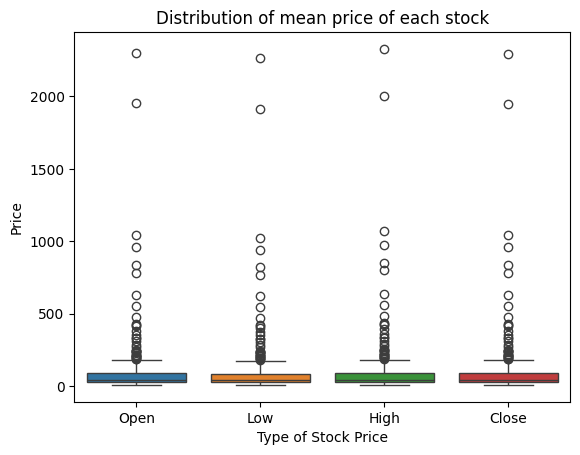

In [23]:
sns.boxplot(data=df_mean)

plt.xlabel('Type of Stock Price')
plt.ylabel('Price')
plt.title('Distribution of mean price of each stock')
# plt.savefig('各公司平均股價')

Text(0.5, 1.0, 'Distribution of mean price of each stock')

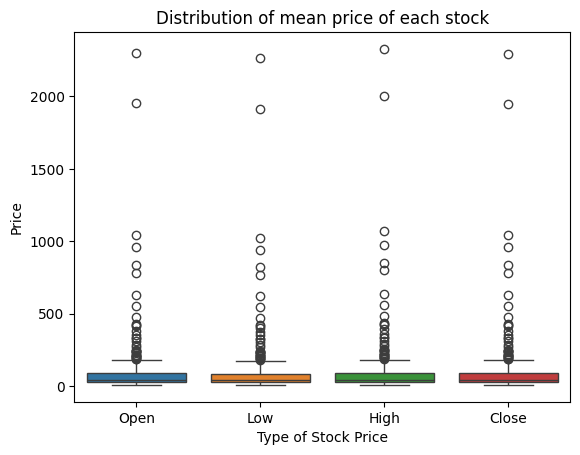

In [24]:
df_mean1 = pd.DataFrame()

for co in list(df_cont['coid'].unique()):
    subset = df_cont[df_cont['coid'] == co][['Open', 'Low', 'High', 'Close']]
    col_means = subset.mean()
    df_mean1 = pd.concat([df_mean1, col_means.to_frame().T], ignore_index = True)
    
sns.boxplot(data=df_mean)

plt.xlabel('Type of Stock Price')
plt.ylabel('Price')
plt.title('Distribution of mean price of each stock')

### 變數圖表
以各公司為組別，畫出各變量的時間序列圖

In [25]:
df_m = df_m.drop_duplicates(subset = ['Sales_Accumulated', 'Sales_Monthly'])

In [26]:
variable = list(df_m.columns)
variable.remove('coid')
variable.remove('mdate')
    
for v in variable:
    plt.xlabel('date')
    plt.ylabel(str(v))
    for co in list(df_m['coid'].unique()):
        subset = df_m[df_m['coid'] == co]
        subset['mdate'] = [datetime.strptime(date, '%Y-%m-%d') for date in subset['mdate']]
        plt.plot(subset['mdate'], subset[v], linewidth= 0.5, label= str(co))
        max_date = max(subset['mdate'])
        plt.text(max_date, list(subset[v])[-1], str(co), fontsize=5, color='blue', verticalalignment='center')
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y')) # Format years
        plt.gca().xaxis.set_major_locator(mdates.YearLocator()) # Show every year
    plt.tight_layout()
    filename = str(v) + ' TS plot.png'
    plt.savefig(filename)
    plt.clf()

C:\Users\USER\AppData\Local\Temp\ipykernel_2428\2686223189.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['mdate'] = [datetime.strptime(date, '%Y-%m-%d') for date in subset['mdate']]


<Figure size 640x480 with 0 Axes>

In [27]:
df_q = df_q.drop_duplicates(subset = list(df_q.drop(columns = ['coid', 'mdate']).columns))

In [27]:
variable = list(df_q.columns)
variable.remove('coid')
variable.remove('mdate')
    
for v in variable:
    plt.xlabel('date')
    plt.ylabel(str(v))
    for co in list(df_q['coid'].unique()):
        subset = df_q[df_q['coid'] == co]
        subset['mdate'] = [datetime.strptime(date, '%Y-%m-%d') for date in subset['mdate']]
        plt.plot(subset['mdate'], subset[v], linewidth= 0.5, label= str(co), marker = 'o')
        max_date = max(subset['mdate'])
        min_date = min(subset['mdate'])
        plt.text(max_date, list(subset[v])[-1], str(co), fontsize=5, color='blue', verticalalignment='center')
        plt.text(min_date, list(subset[v])[0], str(co), fontsize=5, color='blue', verticalalignment='center')
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y')) # Format years
        plt.gca().xaxis.set_major_locator(mdates.YearLocator()) # Show every year
    plt.tight_layout()
    #filename = str(v) + ' TS plot.png'
    plt.savefig(filename)
    plt.clf()

C:\Users\USER\AppData\Local\Temp\ipykernel_16676\2133860588.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['mdate'] = [datetime.strptime(date, '%Y-%m-%d') for date in subset['mdate']]


<Figure size 640x480 with 0 Axes>

### 類別型資料

In [83]:
df_disc = df_disc.drop_duplicates(subset = ['coid'])

In [87]:
count = df_disc['Industry_Eng'].value_counts()
total_counts = sum(count)
proportions = [count / total_counts for count in count]
plt.xlabel('Industry')
plt.xticks(rotation=90)
plt.ylabel('proportion')
plt.bar(list(count.index), list(proportions))
plt.tick_params(axis='x', labelsize=5)
plt.tight_layout()
filename = 'Industry_Eng bar plot.png'
plt.savefig(filename)

<Figure size 640x480 with 0 Axes>

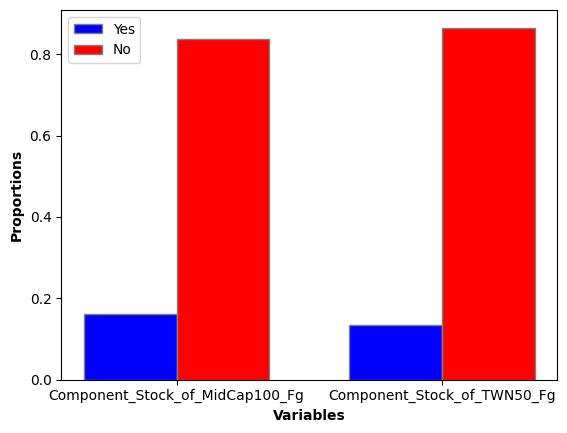

In [115]:
count1 = df_disc['Component_Stock_of_MidCap100_Fg'].value_counts()
count2 = df_disc['Component_Stock_of_TWN50_Fg'].value_counts()

categories = ['Component_Stock_of_MidCap100_Fg', 'Component_Stock_of_TWN50_Fg']

total_count1 = sum(count1)
total_count2 = sum(count2)
proportions1 = [count / total_counts for count in count1]
proportions2 = [count / total_counts for count in count2]

bar_width = 0.35
r1 = np.arange(2)
r2 = [x + bar_width for x in r1]

plt.bar(r1, (proportions1[1], proportions2[1]), color='b', width=bar_width, edgecolor='grey', label='Yes')
plt.bar(r2, (proportions1[0], proportions2[0]), color='r', width=bar_width, edgecolor='grey', label='No')

plt.xlabel('Variables', fontweight='bold')
plt.ylabel('Proportions', fontweight='bold')
plt.xticks([r + bar_width/2 for r in range(len(categories))], categories)
plt.legend()

filename = 'Midcap100 n TWN50 bar plot.png'
plt.savefig(filename)

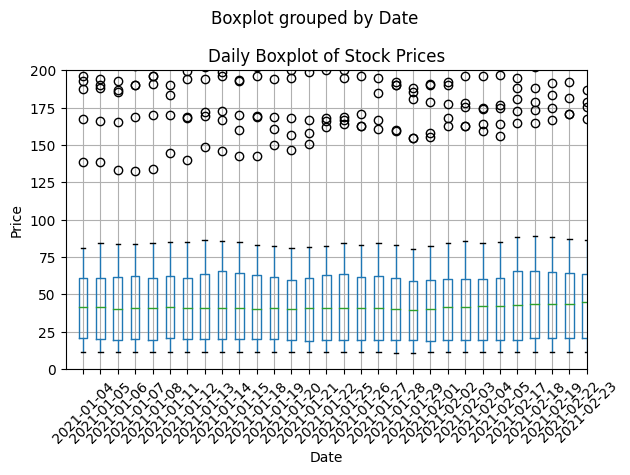

In [94]:
import pandas as pd
import matplotlib.pyplot as plt

data = {'Date': df_sample['mdate'],
    'Company': df_sample['coid'],
    'Price': df_sample['Close']}
df_temp = pd.DataFrame(data)

# Convert 'Date' column to datetime
df_temp.set_index('Date', inplace=True)

# Create a figure and axis object
fig, ax = plt.subplots()

# Create daily boxplot
df_temp.boxplot(column='Price', by='Date', ax=ax)
ax.set_ylim(0, 200)
ax.set_xlim(0, 30)
#Rotate x-axis labels for better readability
plt.xticks(rotation=45)


# Add labels and title
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Daily Boxplot of Stock Prices')

# Show plot
plt.tight_layout()
plt.show()


# 指標生成

In [25]:
def calculate_bollinger_bands(data, window=20, std_multiplier=2):
    # Calculate rolling mean and standard deviation
    rolling_mean = data['Close'].rolling(window=window).mean()
    rolling_std = data['Close'].rolling(window=window).std()

    # Calculate upper and lower bands
    upper_band2 = rolling_mean + (rolling_std * std_multiplier)
    upper_band1 = rolling_mean + rolling_std
    lower_band2 = rolling_mean - (rolling_std * std_multiplier)
    lower_band1 = rolling_mean - rolling_std
    
    return upper_band2, upper_band1, rolling_mean, lower_band1, lower_band2

# Assuming 'data' is a DataFrame containing time series data with a 'Close' column
# Replace 'data' with your actual DataFrame
upper_band2, upper_band1, center_band, lower_band1, lower_band2 = calculate_bollinger_bands(df)

# Print upper and lower bands for the latest day
# print("Upper Band at day t:", upper_band.iloc[-1])
# print('center of the band:', center_band.iloc[-1])
# print("Lower Band at day t:", lower_band.iloc[-1])

In [26]:
def calculate_rsi(data, window=14):
    # Calculate price changes
    delta = data['Close'].diff()

    # Separate positive and negative changes
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    # Calculate average gain and average loss over the window
    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()

    # Calculate relative strength (RS)
    rs = avg_gain / avg_loss

    # Calculate RSI
    rsi = 100 - (100 / (1 + rs))

    return rsi

# Assuming 'data' is a DataFrame containing time series data with a 'Close' column
# Replace 'data' with your actual DataFrame
rsi = calculate_rsi(df)

rsi

0               NaN
1          0.000000
2          0.000000
3          0.000000
4         22.222222
            ...    
272381    70.707071
272382    71.844660
272383    68.421053
272384    70.000000
272385    63.855422
Name: Close, Length: 269410, dtype: float64

In [27]:
rsi = pd.Series()
bollinger_bands = pd.DataFrame()
for company in list(df['coid'].unique()):
    subset = df[df['coid'] == company]
    
    rsi_temp = calculate_rsi(subset)
    rsi = pd.concat([rsi, rsi_temp])
    
    upper_band2_temp, upper_band1_temp, centerline_temp, lower_band1_temp,lower_band2_temp = calculate_bollinger_bands(subset)
    bands_df_temp = pd.DataFrame({'upper_band2': upper_band2_temp, 'upper_band1': upper_band1_temp,
                                  'centerline': centerline_temp, 
                                  'lower_band1': lower_band1_temp, 'lower_band2': lower_band2_temp})
    bollinger_bands = pd.concat([bollinger_bands, bands_df_temp], axis = 0)

bollinger_bands

C:\Users\USER\AppData\Local\Temp\ipykernel_14312\48296121.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  rsi = pd.Series()


,upper_band2,upper_band1,centerline,lower_band1,lower_band2
0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
272381,168.708737,159.416868,150.125,140.833132,131.541263
272382,169.250616,159.850308,150.450,141.049692,131.649384
272383,169.780025,160.377512,150.975,141.572488,132.169975
272384,171.478721,161.689360,151.900,142.110640,132.321279


In [28]:
rsi

0               NaN
1          0.000000
2          0.000000
3          0.000000
4         22.222222
            ...    
272381    70.707071
272382    71.844660
272383    68.421053
272384    70.000000
272385    63.855422
Length: 269410, dtype: float64

In [29]:
df = pd.concat([df, bollinger_bands, rsi], axis = 1)
df = df.rename(columns = {0 : 'RSI'})
df

,coid,mdate,Component_Stock_of_MidCap100_Fg,Component_Stock_of_TWN50_Fg,Industry_Eng,Transaction,Close,Open,PBR_TWSE,Volume_1000_Shares,...,Net_Operating_Income_Loss_Q,Total_Assets_Growth_Rate_Q,Operating_Income_Rate_percent_Q,Return_Rate_on_Equity_A_percent_Q,upper_band2,upper_band1,centerline,lower_band1,lower_band2,RSI
0,1101,2021-01-04,N,Y,M1100 Cement,5884.0,43.20,43.20,1.32,13744.0,...,4207576.0,8.58,19.09,1.68,NaN,NaN,NaN,NaN,NaN,NaN
1,1101,2021-01-05,N,Y,M1100 Cement,5512.0,43.10,43.25,1.32,16631.0,...,4207576.0,8.58,19.09,1.68,NaN,NaN,NaN,NaN,NaN,0.000000
2,1101,2021-01-06,N,Y,M1100 Cement,7543.0,42.95,43.10,1.32,19007.0,...,4207576.0,8.58,19.09,1.68,NaN,NaN,NaN,NaN,NaN,0.000000
3,1101,2021-01-07,N,Y,M1100 Cement,8180.0,42.85,42.95,1.31,21050.0,...,4207576.0,8.58,19.09,1.68,NaN,NaN,NaN,NaN,NaN,0.000000
4,1101,2021-01-08,N,Y,M1100 Cement,7092.0,42.95,42.90,1.32,17406.0,...,4207576.0,8.58,19.09,1.68,NaN,NaN,NaN,NaN,NaN,22.222222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272381,6139,2023-12-25,N,N,M2300 Electronics,10977.0,154.00,161.00,3.51,15533.0,...,1484425.0,35.16,10.19,9.47,168.708737,159.416868,150.125,140.833132,131.541263,70.707071
272382,6139,2023-12-26,N,N,M2300 Electronics,1997.0,156.50,154.00,3.57,2442.0,...,1484425.0,35.16,10.19,9.47,169.250616,159.850308,150.450,141.049692,131.649384,71.844660
272383,6139,2023-12-27,N,N,M2300 Electronics,2425.0,156.00,155.00,3.56,3225.0,...,1484425.0,35.16,10.19,9.47,169.780025,160.377512,150.975,141.572488,132.169975,68.421053
272384,6139,2023-12-28,N,N,M2300 Electronics,9370.0,164.50,156.50,3.75,12115.0,...,1484425.0,35.16,10.19,9.47,171.478721,161.689360,151.900,142.110640,132.321279,70.000000


In [30]:
df['Component_Stock_of_MidCap100_Fg'].replace('N', 0,inplace=True)
df['Component_Stock_of_MidCap100_Fg'].replace('Y', 1,inplace=True)
df['Component_Stock_of_TWN50_Fg'].replace('N', 0,inplace=True)
df['Component_Stock_of_TWN50_Fg'].replace('Y', 2,inplace=True)
df['Component_Stock(2:TWN50, 1:MidCap100, 0:None)'] = df['Component_Stock_of_MidCap100_Fg'] + df['Component_Stock_of_TWN50_Fg']

In [31]:
df

,coid,mdate,Component_Stock_of_MidCap100_Fg,Component_Stock_of_TWN50_Fg,Industry_Eng,Transaction,Close,Open,PBR_TWSE,Volume_1000_Shares,...,Total_Assets_Growth_Rate_Q,Operating_Income_Rate_percent_Q,Return_Rate_on_Equity_A_percent_Q,upper_band2,upper_band1,centerline,lower_band1,lower_band2,RSI,"Component_Stock(2:TWN50, 1:MidCap100, 0:None)"
0,1101,2021-01-04,0,2,M1100 Cement,5884.0,43.20,43.20,1.32,13744.0,...,8.58,19.09,1.68,NaN,NaN,NaN,NaN,NaN,NaN,2
1,1101,2021-01-05,0,2,M1100 Cement,5512.0,43.10,43.25,1.32,16631.0,...,8.58,19.09,1.68,NaN,NaN,NaN,NaN,NaN,0.000000,2
2,1101,2021-01-06,0,2,M1100 Cement,7543.0,42.95,43.10,1.32,19007.0,...,8.58,19.09,1.68,NaN,NaN,NaN,NaN,NaN,0.000000,2
3,1101,2021-01-07,0,2,M1100 Cement,8180.0,42.85,42.95,1.31,21050.0,...,8.58,19.09,1.68,NaN,NaN,NaN,NaN,NaN,0.000000,2
4,1101,2021-01-08,0,2,M1100 Cement,7092.0,42.95,42.90,1.32,17406.0,...,8.58,19.09,1.68,NaN,NaN,NaN,NaN,NaN,22.222222,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272381,6139,2023-12-25,0,0,M2300 Electronics,10977.0,154.00,161.00,3.51,15533.0,...,35.16,10.19,9.47,168.708737,159.416868,150.125,140.833132,131.541263,70.707071,0
272382,6139,2023-12-26,0,0,M2300 Electronics,1997.0,156.50,154.00,3.57,2442.0,...,35.16,10.19,9.47,169.250616,159.850308,150.450,141.049692,131.649384,71.844660,0
272383,6139,2023-12-27,0,0,M2300 Electronics,2425.0,156.00,155.00,3.56,3225.0,...,35.16,10.19,9.47,169.780025,160.377512,150.975,141.572488,132.169975,68.421053,0
272384,6139,2023-12-28,0,0,M2300 Electronics,9370.0,164.50,156.50,3.75,12115.0,...,35.16,10.19,9.47,171.478721,161.689360,151.900,142.110640,132.321279,70.000000,0


In [32]:
df.drop(columns = ['Component_Stock_of_MidCap100_Fg', 'Component_Stock_of_TWN50_Fg'], inplace = True)
df['Component_Stock(2:TWN50, 1:MidCap100, 0:None)'].replace('NN', 0,inplace=True)
df['Component_Stock(2:TWN50, 1:MidCap100, 0:None)'].replace('YN', 1,inplace=True)
df['Component_Stock(2:TWN50, 1:MidCap100, 0:None)'].replace('NY', 2,inplace=True)
df = df.reset_index()



In [34]:
df = df.drop(columns=['index'],inplace = False)
buysell = pd.Series()

def extend_values(series):
    extended_series = series.copy()
    for i, value in enumerate(series):
        if value == -1:
            if i > 0:
                extended_series[i - 1] = -1
            if i < (len(series) - 1):
                extended_series[i + 1] = -1
        elif value == 1:
            if i > 0:
                extended_series[i - 1] = 1
            if i < (len(series) - 1):
                extended_series[i + 1] = 1
    return extended_series

for coid in df['coid'].unique():    
    subset = df[df['coid'] == coid]
    buysell_temp = []
    index = list(range(len(subset['Close'])))
    first_valid_index = subset['upper_band2'].first_valid_index()
    close_pre = subset['Close'][first_valid_index]
    ub2_pre = subset['upper_band2'][first_valid_index]
    ub1_pre = subset['upper_band1'][first_valid_index]
    lb1_pre = subset['lower_band1'][first_valid_index]
    lb2_pre = subset['lower_band2'][first_valid_index]
    for i, close, ub2, ub1, lb1, lb2 in zip(index, subset['Close'], subset['upper_band2'], subset['upper_band1'], subset['lower_band1'], subset['lower_band2']):
        if i <= 18:
            buysell_temp.append(None)
            continue
        if (close_pre <= ub2_pre) & (close > ub2) :
            buysell_temp.append(1)
        elif (close_pre >= ub1_pre) & (close < ub1):
            buysell_temp.append(-1)
        elif (close_pre >= lb2_pre) & (close < lb2):
            buysell_temp.append(1)
        elif (close_pre <= lb1_pre) & (close > lb1):
            buysell_temp.append(-1)
        else:
            buysell_temp.append(0)
        close_pre = close
        ub2_pre = ub2
        ub1_pre = ub1 
        lb1_pre = lb1
        lb2_pre = lb2
    #buysell_temp = extend_values(buysell_temp)  #***
    buysell = pd.concat([buysell, pd.Series(buysell_temp)])

C:\Users\USER\AppData\Local\Temp\ipykernel_14312\4112519383.py:2: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  buysell = pd.Series()


In [35]:
buysell.shape #269410

(269410,)

In [36]:
buysell.value_counts()

 0.0    216883
-1.0     30848
 1.0     14611
dtype: int64

In [37]:
buysell = buysell.reset_index(drop=True)
df['Signals(1:Buy,0:None,-1:Sell)'] = buysell
df

,coid,mdate,Industry_Eng,Transaction,Close,Open,PBR_TWSE,Volume_1000_Shares,PER_TWSE,Dividend_Yield_TWSE,...,Operating_Income_Rate_percent_Q,Return_Rate_on_Equity_A_percent_Q,upper_band2,upper_band1,centerline,lower_band1,lower_band2,RSI,"Component_Stock(2:TWN50, 1:MidCap100, 0:None)","Signals(1:Buy,0:None,-1:Sell)"
0,1101,2021-01-04,M1100 Cement,5884.0,43.20,43.20,1.32,13744.0,10.29,6.94,...,19.09,1.68,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN
1,1101,2021-01-05,M1100 Cement,5512.0,43.10,43.25,1.32,16631.0,10.26,6.96,...,19.09,1.68,NaN,NaN,NaN,NaN,NaN,0.000000,2,NaN
2,1101,2021-01-06,M1100 Cement,7543.0,42.95,43.10,1.32,19007.0,10.23,6.98,...,19.09,1.68,NaN,NaN,NaN,NaN,NaN,0.000000,2,NaN
3,1101,2021-01-07,M1100 Cement,8180.0,42.85,42.95,1.31,21050.0,10.20,7.00,...,19.09,1.68,NaN,NaN,NaN,NaN,NaN,0.000000,2,NaN
4,1101,2021-01-08,M1100 Cement,7092.0,42.95,42.90,1.32,17406.0,10.23,6.98,...,19.09,1.68,NaN,NaN,NaN,NaN,NaN,22.222222,2,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269405,6139,2023-12-25,M2300 Electronics,10977.0,154.00,161.00,3.51,15533.0,16.68,2.27,...,10.19,9.47,168.708737,159.416868,150.125,140.833132,131.541263,70.707071,0,0.0
269406,6139,2023-12-26,M2300 Electronics,1997.0,156.50,154.00,3.57,2442.0,16.96,2.24,...,10.19,9.47,169.250616,159.850308,150.450,141.049692,131.649384,71.844660,0,0.0
269407,6139,2023-12-27,M2300 Electronics,2425.0,156.00,155.00,3.56,3225.0,16.90,2.24,...,10.19,9.47,169.780025,160.377512,150.975,141.572488,132.169975,68.421053,0,0.0
269408,6139,2023-12-28,M2300 Electronics,9370.0,164.50,156.50,3.75,12115.0,17.82,2.13,...,10.19,9.47,171.478721,161.689360,151.900,142.110640,132.321279,70.000000,0,0.0


In [39]:
df.to_csv('clean_wo_extend.csv', header = True, index = False)